In [1]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sv = survey('data/survey2/')

In [3]:
sv.num_processor()

In [4]:
df = sv.fin_data

### split

In [5]:
dfc = df.copy()

y = dfc.pop('employed').values
X = dfc.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

## Random Forest

In [7]:
rf=RandomForestClassifier(n_jobs = -1,random_state=0)
scores = cross_val_score(rf,X,y,cv =10, n_jobs=-1,scoring='roc_auc')
np.mean(scores)

0.75316992748189349

In [8]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

[[273 233]
 [215 754]]


/Users/yleng/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


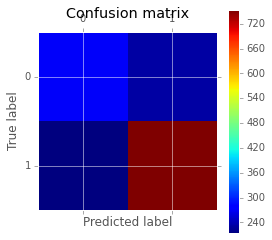

In [9]:
plot_confusion_matrix(rf,X_test,y_test)

roc_auc_score : 0.722322838018


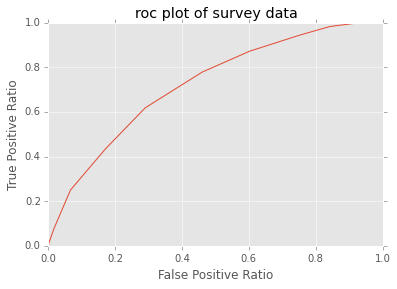

In [10]:
plot_roc(rf,X_test,y_test)

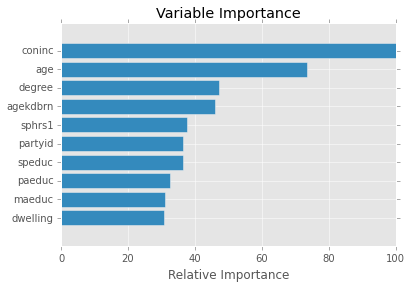

In [11]:
plot_importance(rf,dfc)

# shrink the size

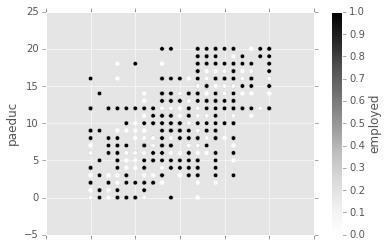

In [12]:
dfc = df.copy()
dfc.plot(x = 'maeduc', y = 'paeduc', kind = 'scatter', c = 'employed')


### mather,father,spouse highest education all rank very high.  But they are correlated somehow, so we can combine them by taking the average. This new variable can be interpreted as average family members' education. 

In [13]:
dfc = df.copy()
dfc['educom'] = (dfc.paeduc+dfc.maeduc+dfc.speduc)/3        
dfc.drop(['paeduc','maeduc','speduc'], axis =1, inplace=True)

In [14]:
y = dfc.pop('employed').values

X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [15]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)

In [16]:
s = cross_val_score(rf,X,y,cv =10,n_jobs=-1, scoring='roc_auc')
np.mean(s)

0.75480438190289934

In [17]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

roc_auc_score : 0.742105971211


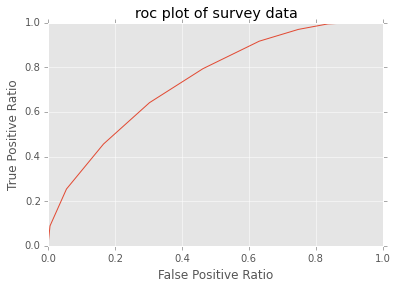

In [18]:
plot_roc(rf,X_test,y_test)

## Determine how many features to keep

To determine the number of features to keep, I reduced the dimension by reduce column according to the level of feature of importance. Also, in order to classify the objects, I need to make a balance.

In [19]:
f = rf.feature_importances_.argsort()

In [20]:
clis = dfc.columns

In [21]:
dfs = dfc[clis[f]].copy()

In [22]:
v = dfs.columns[110:]

In [23]:
var = extract_variables('data/survey2/GSS.sps')
re_var = {k:v for (v,k) in var.iteritems()}

In [24]:
for i in v:
    if i.upper() in re_var:
        print i,':', re_var[i.upper()]

natpark : Parks and recreation
marital : Marital status
divlaw : Divorce laws
workhard : To work hard
divorce : Ever been divorced or separated
fechld : Mother working doesn't hurt children
natsoc : Social security
helpoth : To help others
mawrkgrw : Mothers employment when r was 16
natroad : Highways and bridges
mobile16 : Geographic mobility since age 16
socfrend : Spend evening with friends
parsol : Rs living standard compared to parents
natrace : Improving the conditions of blacks
fefam : Better for man to work, woman tend home
courts : Courts dealing with criminals
meovrwrk : Men hurt family when focus on work too much
socbar : Spend evening at bar
fund : How fundamentalist is r currently
reliten : Strength of affiliation
finrela : Opinion of family income
incom16 : Rs family income when 16 yrs old
polviews : Think of self as liberal or conservative
res16 : Type of place lived in when 16 yrs old
dwelling : Type of structure
class_ : Subjective class identification
partyid : Politi

In [25]:
rf_plot = RandomForestClassifier(n_jobs =-1,random_state=0)
X = dfs.values

(0, 60)

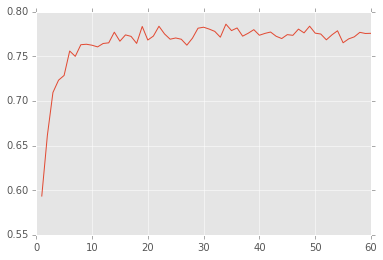

In [26]:
roclis = []
for i in f:
    if X.shape[1]==1:
        break
    X = X[:,1:]
    scores = cross_val_score(rf_plot,X,y, scoring='roc_auc',n_jobs=-1)
    roclis.append(np.mean(scores))


plt.plot(range(142,0,-1),roclis)
plt.xlim(0,60)

### take first 30 important features, make a new model, grid search, and pass down to feature contribution study.

In [27]:
f30 = rf.feature_importances_.argsort()[::-1][:30]

In [28]:
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)

In [29]:
slct=dfc.columns[f30]

In [30]:
X = dfc[slct].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [32]:
s = cross_val_score(rf_redu,X,y,cv =10,n_jobs=-1,scoring='roc_auc')
np.mean(s)

0.77024780436615226

In [33]:
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

roc_auc_score : 0.756165558396


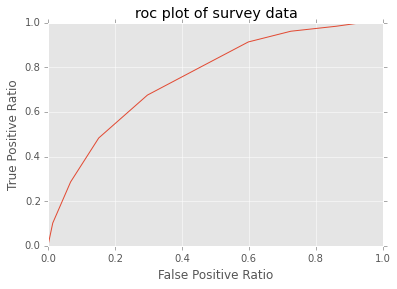

In [34]:
plot_roc(rf_redu,X_test,y_test)

## To do:
1. Grid search
2. pickle model and engineered data frame, or remember the settings.
3. pass it down to feature contribution algorithm

## To remember:
**train_test_split(X, y, test_size=0.3, random_state=90)**

**RandomForestClassifier(n_jobs=-1,random_state=0)**